#### Imports


In [1]:
from zoish.feature_selectors.shap_selectors import ShapFeatureSelector
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import OrdinalEncoder
import xgboost
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.linear_model import LinearRegression

In this module, the default logging will be applied. The error is [Errno 2] No such file or directory: 'zoish/config.yaml' which will be skipped!
2023-02-24 18:50:42,625 :: graphviz._tools :: deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2023-02-24 18:50:42,630 :: graphviz._tools :: deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2023-02-24 18:50:42,637 :: graphviz._tools :: deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2023-02-24 18:50:42,643 :: graphviz._tools :: deprecate positional args: graphviz.backend.viewing.view(['quiet'])
2023-02-24 18:50:42,658 :: graphviz._tools :: deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
2023-02-24 18:50:42,660 :: graphviz._tools :: deprecate posi

#### Computer Hardware Data Set (a regression problem)
  
###### https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
# column names
col_names=[
    "vendor name",
    "Model Name",
    "MYCT",
    "MMIN",
    "MMAX",
    "CACH",
    "CHMIN",
    "CHMAX",
    "PRP"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')


#### Train test split

In [3]:
X = data.loc[:, data.columns != "PRP"]
y = data.loc[:, data.columns == "PRP"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, random_state=42)


#### Define feature selector step 


In [4]:
shap_feature_selector_factory = (
    ShapFeatureSelector.shap_feature_selector_factory.set_model_params(
        X=X_train,
        y=y_train,
        verbose=10,
        random_state=0,
        estimator=xgboost.XGBRegressor(),
        estimator_params={
            "max_depth": [4, 5],
        },
        fit_params = {
            "callbacks": None,
        },
        method="tunesearch",
        # if n_features=None only the threshold will be considered as a cut-off of features grades.
        # if threshold=None only n_features will be considered to select the top n features.
        # if both of them are set to some values, the threshold has the priority for selecting features.
        n_features=5,
        threshold = None,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
    )
    .set_shap_params(
        model_output="raw",
        feature_perturbation="interventional",
        algorithm="v2",
        shap_n_jobs=-1,
        memory_tolerance=-1,
        feature_names=None,
        approximate=False,
        shortcut=False,
    )
    .set_tunesearchcv_params(
            measure_of_accuracy=None,
            verbose=3,
            n_jobs=None,
            cv=3,
            early_stopping=None, 
            n_trials=10,
            # if measure_of_accuracy=None, scoring will be used.
            scoring='r2', 
            refit=True, 
            error_score='raise', 
            return_train_score=False, 
            local_dir='~/ray_results', 
            name=None, 
            max_iters=1, 
            search_optimization='hyperopt',
            use_gpu=False, 
            loggers=None, 
            pipeline_auto_early_stop=True, 
            stopper=None, 
            time_budget_s=None, 
            mode=None,
            search_kwargs=None, 

)
)

#### Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


#### Define pipeline

In [6]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ("sfsf", shap_feature_selector_factory),
            # add any regression model from sklearn e.g., LinearRegression
            ('regression', LinearRegression())


 ])



#### Run Pipeline

In [7]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


2023-02-24 18:50:48,606 :: root :: Building Best Estimator by TuneSearchCV !
2023-02-24 18:50:48,608 :: dev :: The optimization will be based on r2 metric!
2023-02-24 18:50:48,608 :: dev :: The optimization will be based on r2 metric!
2023-02-24 18:50:48,614 :: ray.tune.tune :: Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.


2023-02-24 18:50:55,321	INFO worker.py:1538 -- Started a local Ray instance.


Trial name,average_test_score,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,objective,pid,split0_test_score,split1_test_score,split2_test_score,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
_Trainable_0554badd,0.853564,2023-02-24_18-51-52,True,,95cda965f9ec44e9868f4ddcee6a9b7b,hjavedani-MB,1,127.0.0.1,0.853564,71410,0.893561,0.760561,0.90657,0.423213,0.423213,0.423213,1677293512,0,,1,0554badd,0.294101
_Trainable_083c71fb,0.849402,2023-02-24_18-51-30,True,,7958ef4afabc444b9a9359c6f5c55de2,hjavedani-MB,1,127.0.0.1,0.849402,71403,0.884652,0.776499,0.887055,0.443348,0.443348,0.443348,1677293490,0,,1,083c71fb,0.173278
_Trainable_2ad61e6a,0.849402,2023-02-24_18-51-52,True,,032f45ece6844dbb973f5a8559bef98f,hjavedani-MB,1,127.0.0.1,0.849402,71406,0.884652,0.776499,0.887055,0.421595,0.421595,0.421595,1677293512,0,,1,2ad61e6a,0.350618
_Trainable_36d3c337,0.853564,2023-02-24_18-51-15,True,,6984fdc10a3a403a9934fc66362858d4,hjavedani-MB,1,127.0.0.1,0.853564,71395,0.893561,0.760561,0.90657,0.148982,0.148982,0.148982,1677293475,0,,1,36d3c337,0.187644
_Trainable_451a8275,0.853564,2023-02-24_18-51-30,True,,6984fdc10a3a403a9934fc66362858d4,hjavedani-MB,1,127.0.0.1,0.853564,71395,0.893561,0.760561,0.90657,0.323977,0.323977,0.323977,1677293490,0,,1,451a8275,0.187644
_Trainable_585d5eb2,0.849402,2023-02-24_18-51-52,True,,d47def05561f4c8988d9323bebba3458,hjavedani-MB,1,127.0.0.1,0.849402,71407,0.884652,0.776499,0.887055,0.455043,0.455043,0.455043,1677293512,0,,1,585d5eb2,0.343968
_Trainable_6cd63e09,0.853564,2023-02-24_18-51-52,True,,a462f45390ea4c13bac1de88205f09bc,hjavedani-MB,1,127.0.0.1,0.853564,71409,0.893561,0.760561,0.90657,0.476581,0.476581,0.476581,1677293512,0,,1,6cd63e09,0.370126
_Trainable_96e8994f,0.853564,2023-02-24_18-51-30,True,,6984fdc10a3a403a9934fc66362858d4,hjavedani-MB,1,127.0.0.1,0.853564,71395,0.893561,0.760561,0.90657,0.186496,0.186496,0.186496,1677293490,0,,1,96e8994f,0.187644
_Trainable_e4fb80d9,0.853564,2023-02-24_18-51-52,True,,fa15936c004a418e815f5d2cb04b3121,hjavedani-MB,1,127.0.0.1,0.853564,71411,0.893561,0.760561,0.90657,0.431563,0.431563,0.431563,1677293512,0,,1,e4fb80d9,0.397757
_Trainable_ec37ee37,0.849402,2023-02-24_18-51-52,True,,d2b74a66b5b447fb9f05b9f6f7cd8953,hjavedani-MB,1,127.0.0.1,0.849402,71408,0.884652,0.776499,0.887055,0.488734,0.488734,0.488734,1677293512,0,,1,ec37ee37,0.404765


2023-02-24 18:51:52,713	INFO tune.py:762 -- Total run time: 52.44 seconds (52.09 seconds for the tuning loop).


#### plot

2023-02-24 18:51:54,572 :: root :: type of plot is : summary_plot


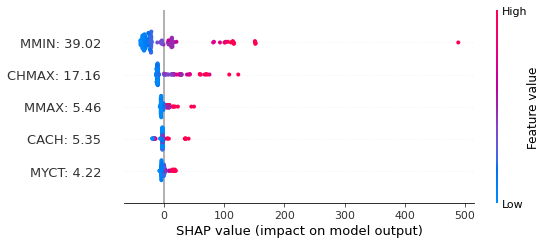

ShapFeatureSelector(X=               vendor name  Model Name  MYCT   MMIN  MMAX  CACH  CHMIN  CHMAX
cdc          cyber:170/845          64  5240  20970    30    12     24    208
c.r.d      universe:68/137         320   512   5000     4     1      5     77
cambex             1641-11          50  2000  16000     8     3      6     52
ibm                4341-12         185  2000  16000    16     1      6     76
ibm                 3083:e          26  8000  16000     0     8     16    185
...                    ...         ...   ...    ...   ...   ...    ...    ...
ibm                   38/8         400  4000   8000     0     1      1     32
bti                   5000         350    64     64     0     1      4     10
honeywell         dps:8/20         140  2000   4000     8     1     20     22
prime            50-750-ii         160  1000   8000...
                    local_dir='~/ray_results', max_iters=1, memory_tolerance=-1,
                    method='tunesearch', model_output='raw', n_features=5,
                    n_trials=10, pipeline_auto_early_stop=True, random_state=0,
                    refit=True, return_train_score=False, scoring='r2',
                    search_optimization='hyperopt', shap_n_jobs=-1,
                    shortcut=False, use_gpu=False, verbose=3,
                    y=           PRP
cdc        136
c.r.d       28
cambex      74
ibm         76
ibm        113
...        ...
ibm         45
bti         15
honeywell   32
prime       43
ibm         18

[140 rows x 1 columns])

In [8]:
ShapFeatureSelector.shap_feature_selector_factory.plot_features_all(
    type_of_plot="summary_plot",
    path_to_save_plot="../plots/shap_optuna_search_regression_summary_plot"
)


#### Check performance of the Pipeline

In [9]:
print('r2 score : ')
print(r2_score(y_test,y_pred))


r2 score : 
0.919944073154188


#### Get access to feature selector instance

In [10]:
print(ShapFeatureSelector.shap_feature_selector_factory.get_feature_selector_instance())